**R packages **

In [1]:
install.packages(c("ggfortify"))
install.packages(c("caret", "dplyr","ggplot2"))
install.packages("randomForest")
install.packages("rpart.plot")
install.packages("rpart")
install.packages("Matrix")
install.packages("xgboost")
install.packages("e1071")
install.packages("visreg")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/

***Linear Model***

                                Model    MSE   RMSE    MAE     R2
11                      ALL VARIABLES 0.1319 0.3632 0.2385 0.8808
8       PT08_S1_CO + C6H6_GT + NOx_GT 0.1496 0.3867 0.2630 0.8649
10                   NOx_GT + C6H6_GT 0.1620 0.4025 0.2811 0.8536
3                PT08_S1_CO + C6H6_GT 0.1791 0.4232 0.3010 0.8382
7       RH + T + NOx_GT + PT08_S4_NO2 0.1836 0.4285 0.3072 0.8341
6  NOx_GT + PT08_S3_NOx + PT08_S4_NO2 0.2669 0.5166 0.3871 0.7589
9                 NOx_GT + PT08_S1_CO 0.2680 0.5177 0.3689 0.7578
4                 NOx_GT + PT08_S5_O3 0.3619 0.6016 0.4557 0.6730
2                          NOx_GT + T 0.4935 0.7025 0.5123 0.5541
1                              NOx_GT 0.5887 0.7673 0.5875 0.4681
5                     PT08_S4_NO2 + T 0.6276 0.7922 0.6287 0.4330


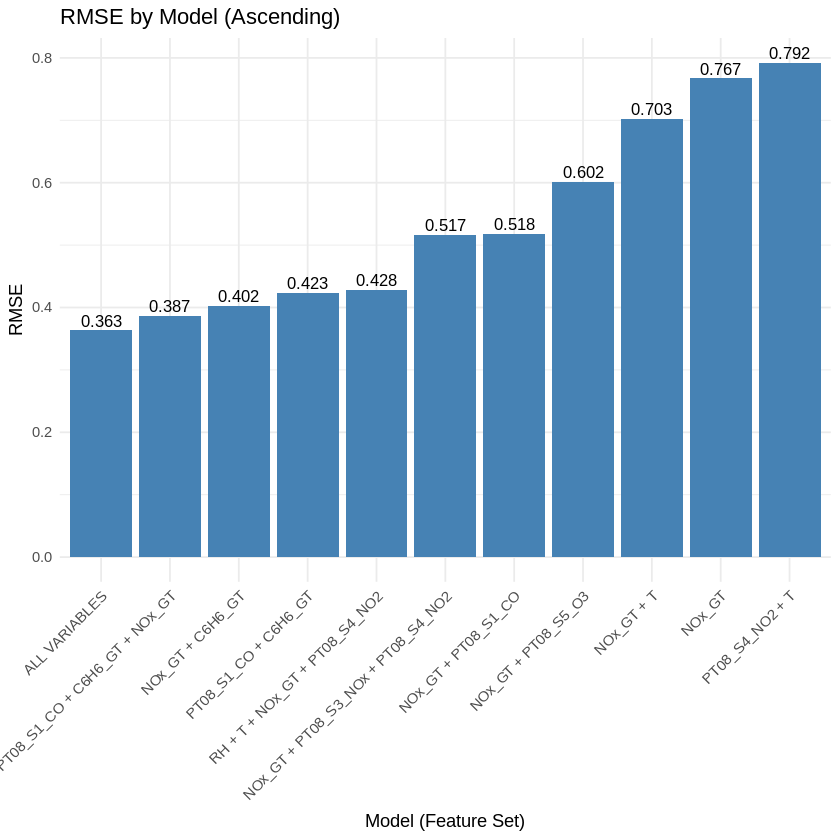

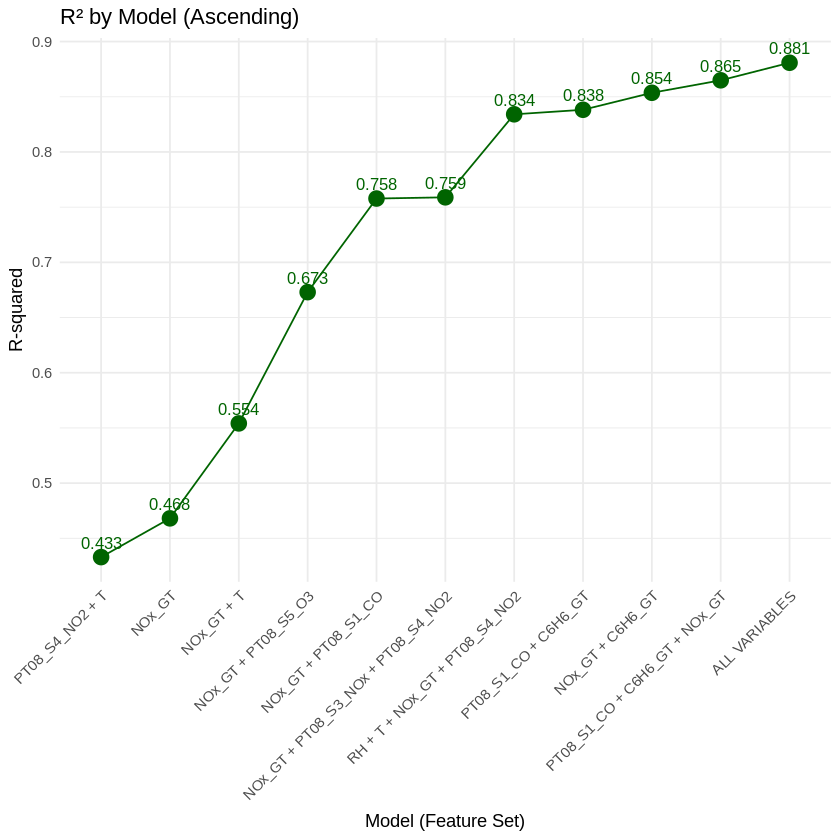

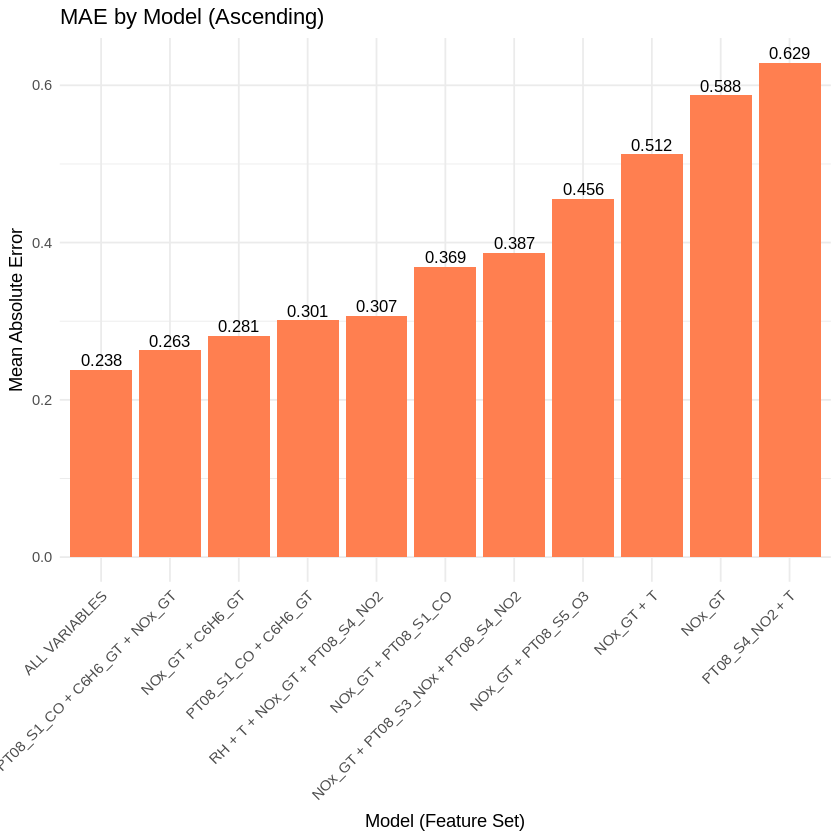

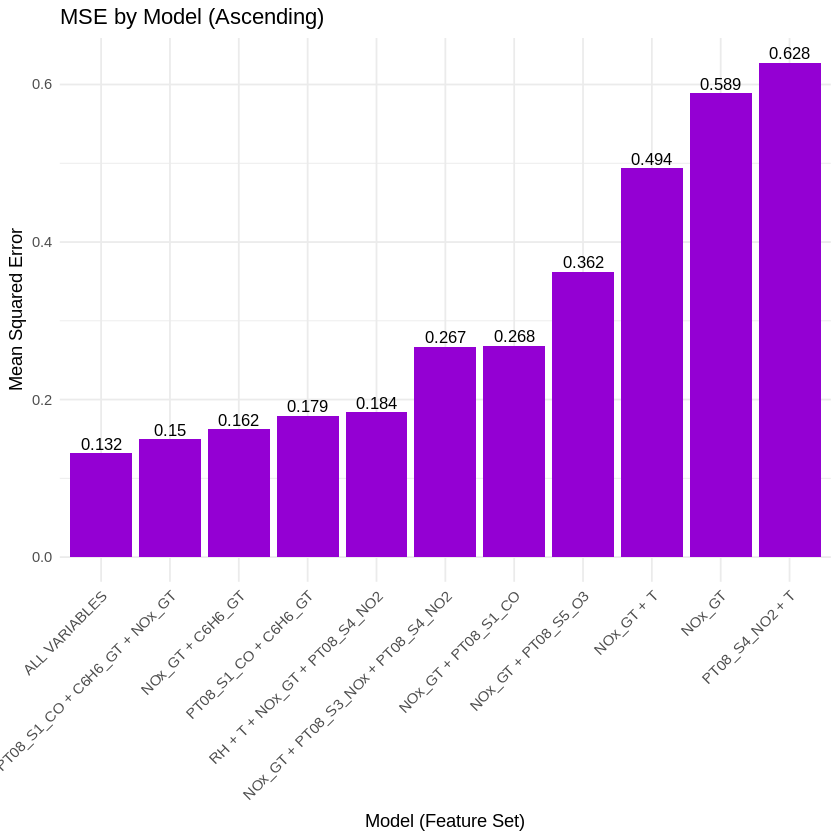

`geom_smooth()` using formula = 'y ~ x'


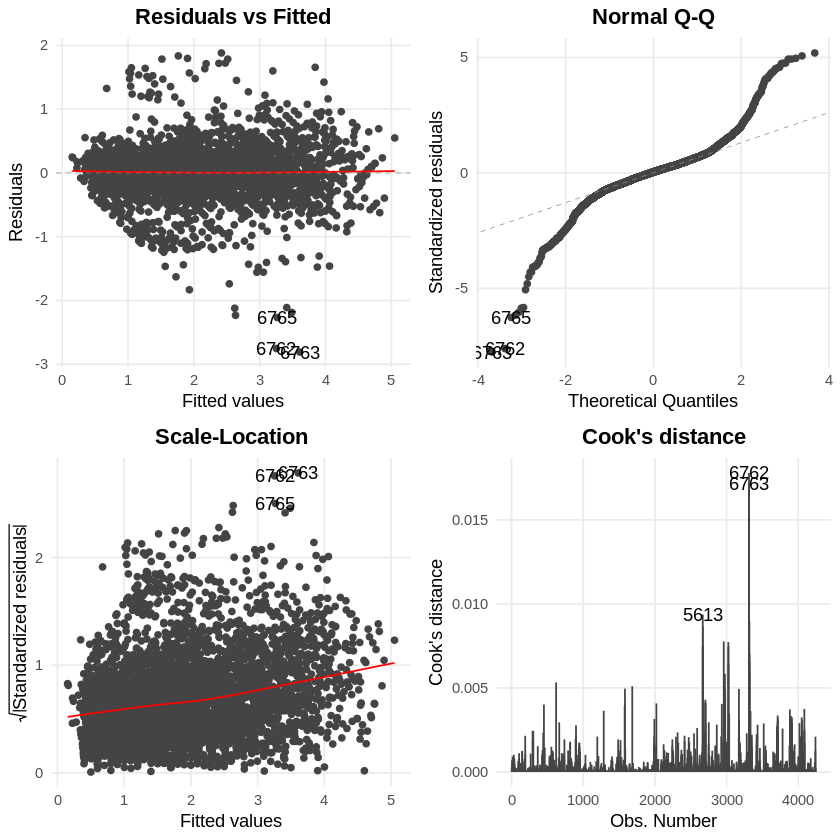

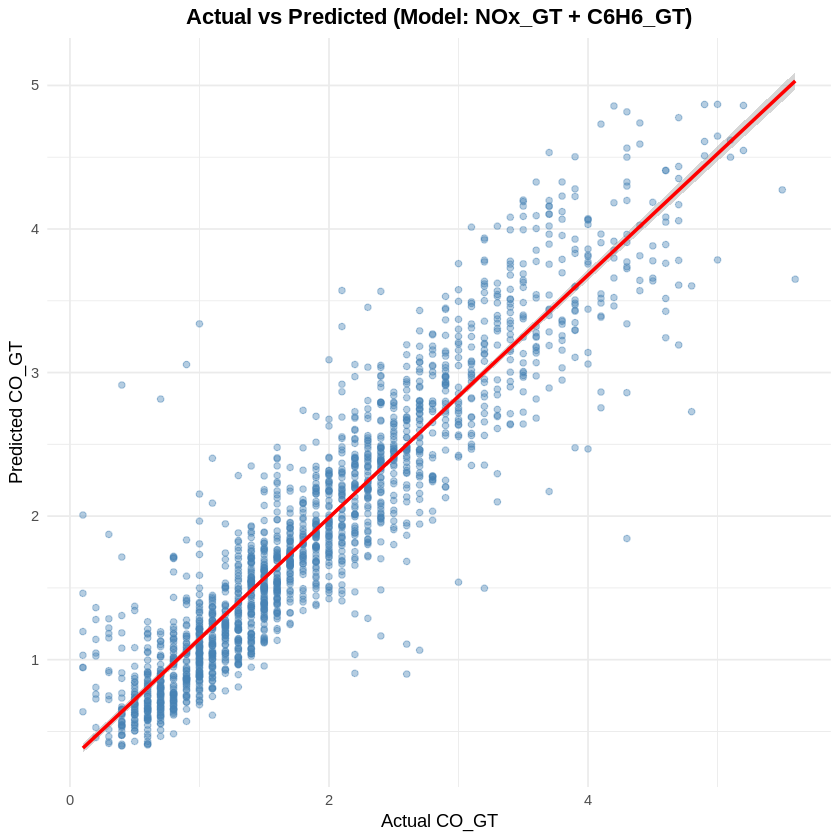

In [32]:

library(caret)
library(dplyr)
library(ggplot2)
library(ggfortify)

# Step 1: Load the dataset
df <- read.csv("/content/AirQualityUCI_Normalized_CO_Target.csv", stringsAsFactors = FALSE)

# Step 2: Remove rows with missing values
df <- df[complete.cases(df), ]

# Step 3: Define features and target
target <- df$CO_GT

all_vars <- c("RH", "PT08_S1_CO", "C6H6_GT", "PT08_S2_NMHC", "NOx_GT",
              "PT08_S3_NOx", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T","AH")

combinations <- list(
  c("NOx_GT"),
  c("NOx_GT", "T"),
  c("PT08_S1_CO", "C6H6_GT"),
  c("NOx_GT", "PT08_S5_O3"),
  c("PT08_S4_NO2", "T"),
  c("NOx_GT", "PT08_S3_NOx", "PT08_S4_NO2"),
  c("RH", "T", "NOx_GT", "PT08_S4_NO2"),
  c("PT08_S1_CO", "C6H6_GT", "NOx_GT"),
  c("NOx_GT", "PT08_S1_CO"),
c("NOx_GT", "C6H6_GT")


)

# Step 4: Train-Test Split
set.seed(123)
train_index <- createDataPartition(target, p = 0.7, list = FALSE)
df_train <- df[train_index, ]
df_test <- df[-train_index, ]

# Step 5: Loop through combinations and evaluate models
results_df <- data.frame(Model = character(), MSE = numeric(), RMSE = numeric(), MAE = numeric(), R2 = numeric(), stringsAsFactors = FALSE)

for (combo in combinations) {
  formula_str <- paste("CO_GT ~", paste(combo, collapse = " + "))
  model <- lm(as.formula(formula_str), data = df_train)

  predictions <- predict(model, newdata = df_test)
  actuals <- df_test$CO_GT
  valid <- complete.cases(predictions, actuals)
  predictions <- predictions[valid]
  actuals <- actuals[valid]

  mse <- mean((predictions - actuals)^2)
  rmse <- sqrt(mse)
  mae <- mean(abs(predictions - actuals))
  r2 <- 1 - sum((predictions - actuals)^2) / sum((actuals - mean(actuals))^2)

  results_df <- rbind(results_df, data.frame(
    Model = paste(combo, collapse = " + "),
    MSE = round(mse, 4),
    RMSE = round(rmse, 4),
    MAE = round(mae, 4),
    R2 = round(r2, 4)
  ))
}

# Step 5B: Full model with all variables
full_formula_str <- paste("CO_GT ~", paste(all_vars, collapse = " + "))
full_model <- lm(as.formula(full_formula_str), data = df_train)

full_preds <- predict(full_model, newdata = df_test)
full_actuals <- df_test$CO_GT
valid_full <- complete.cases(full_preds, full_actuals)
full_preds <- full_preds[valid_full]
full_actuals <- full_actuals[valid_full]

mse_full <- mean((full_preds - full_actuals)^2)
rmse_full <- sqrt(mse_full)
mae_full <- mean(abs(full_preds - full_actuals))
r2_full <- 1 - sum((full_preds - full_actuals)^2) / sum((full_actuals - mean(full_actuals))^2)

results_df <- rbind(results_df, data.frame(
  Model = "ALL VARIABLES",
  MSE = round(mse_full, 4),
  RMSE = round(rmse_full, 4),
  MAE = round(mae_full, 4),
  R2 = round(r2_full, 4)
))

# Step 6: Sort results by R² descending
results_df <- results_df[order(-results_df$R2), ]
print(results_df)

# Step 7: Visualize RMSE in ascending order
results_df_rmse <- results_df[order(results_df$RMSE), ]
results_df_rmse$Model <- factor(results_df_rmse$Model, levels = results_df_rmse$Model)

ggplot(results_df_rmse, aes(x = Model, y = RMSE)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = round(RMSE, 3)), vjust = -0.3, size = 3.5) +
  labs(title = "RMSE by Model (Ascending)", x = "Model (Feature Set)", y = "RMSE") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Step 8: Visualize R² in ascending order
results_df_r2 <- results_df[order(results_df$R2), ]
results_df_r2$Model <- factor(results_df_r2$Model, levels = results_df_r2$Model)

ggplot(results_df_r2, aes(x = Model, y = R2)) +
  geom_point(size = 4, color = "darkgreen") +
  geom_line(group = 1, color = "darkgreen") +
  geom_text(aes(label = round(R2, 3)), vjust = -0.7, size = 3.5, color = "darkgreen") +
  labs(title = "R² by Model (Ascending)", x = "Model (Feature Set)", y = "R-squared") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Step 9: Visualize MAE in ascending order
results_df_mae <- results_df[order(results_df$MAE), ]
results_df_mae$Model <- factor(results_df_mae$Model, levels = results_df_mae$Model)

ggplot(results_df_mae, aes(x = Model, y = MAE)) +
  geom_bar(stat = "identity", fill = "coral") +
  geom_text(aes(label = round(MAE, 3)), vjust = -0.3, size = 3.5) +
  labs(title = "MAE by Model (Ascending)", x = "Model (Feature Set)", y = "Mean Absolute Error") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Step 10: Visualize MSE in ascending order
results_df_mse <- results_df[order(results_df$MSE), ]
results_df_mse$Model <- factor(results_df_mse$Model, levels = results_df_mse$Model)

ggplot(results_df_mse, aes(x = Model, y = MSE)) +
  geom_bar(stat = "identity", fill = "darkviolet") +
  geom_text(aes(label = round(MSE, 3)), vjust = -0.3, size = 3.5) +
  labs(title = "MSE by Model (Ascending)", x = "Model (Feature Set)", y = "Mean Squared Error") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Step 11: Diagnostic plots for full model
autoplot(full_model, which = 1:4, ncol = 2, smooth.colour = "red") +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "white", color = NA),
    strip.background = element_rect(fill = "steelblue", color = "white"),
    strip.text = element_text(color = "white", face = "bold")
  )

# Step 12: Actual vs Predicted Plot for Model: NOx_GT + C6H6_GT
combo_formula <- as.formula("CO_GT ~ NOx_GT + C6H6_GT")
combo_model <- lm(combo_formula, data = df_train)

combo_preds <- predict(combo_model, newdata = df_test)
combo_actuals <- df_test$CO_GT
valid_combo <- complete.cases(combo_preds, combo_actuals)
combo_preds <- combo_preds[valid_combo]
combo_actuals <- combo_actuals[valid_combo]

comparison_combo_df <- data.frame(Actual = combo_actuals, Predicted = combo_preds)

ggplot(comparison_combo_df, aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.4, color = "steelblue") +
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  labs(
    title = "Actual vs Predicted (Model: NOx_GT + C6H6_GT)",
    x = "Actual CO_GT",
    y = "Predicted CO_GT"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5)
  )



***Random Forest Model ***

 Random Forest Performance:
MSE: 0.1146 
RMSE: 0.3386 
MAE: 0.2176 
R²: 0.8964 


`geom_smooth()` using formula = 'y ~ x'


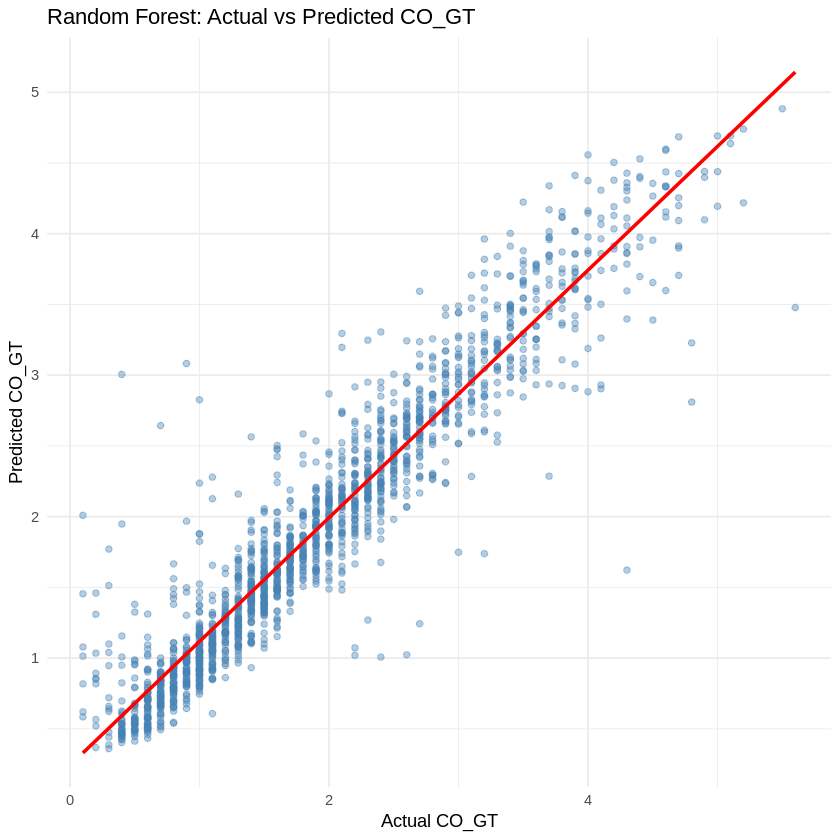

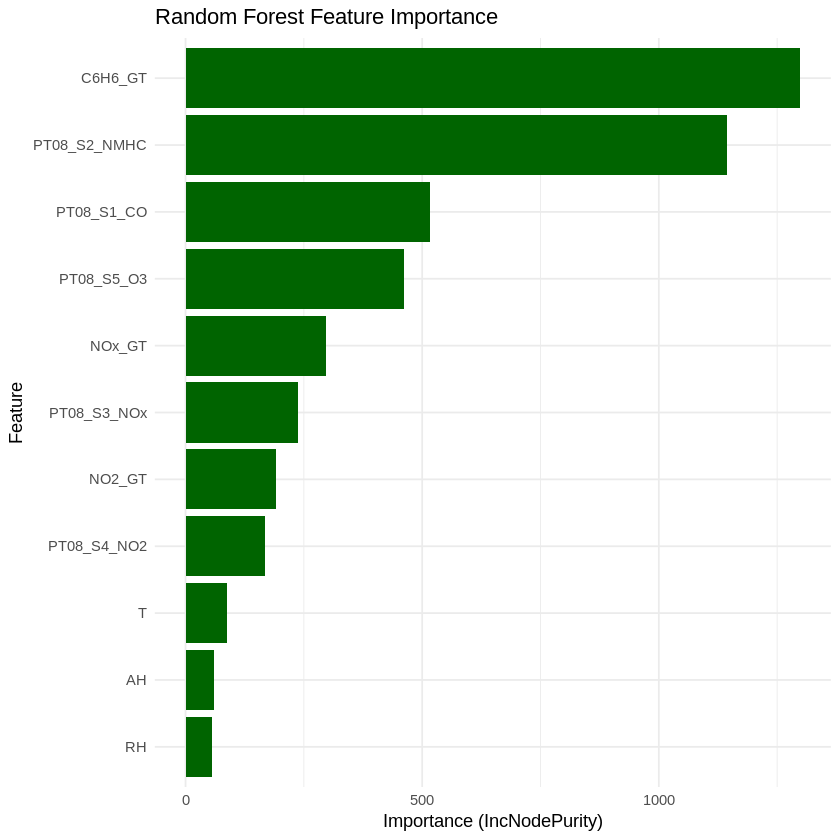

In [31]:
# Load libraries
library(randomForest)
library(caret)
library(ggplot2)

# Step 1: Load and clean the dataset
df <- read.csv("/content/AirQualityUCI_Normalized_CO_Target.csv", stringsAsFactors = FALSE)
df <- df[complete.cases(df), ]

# Step 2: Define features and target
features <- c("RH", "PT08_S1_CO", "C6H6_GT", "PT08_S2_NMHC", "NOx_GT",
              "PT08_S3_NOx", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T", "AH")
target <- "CO_GT"

# Step 3: Train-test split
set.seed(123)  # For reproducibility
train_index <- createDataPartition(df[[target]], p = 0.7, list = FALSE)
df_train <- df[train_index, ]
df_test <- df[-train_index, ]

# Step 4: Fit Random Forest model
set.seed(123)  # Important: seed before model training
rf_model <- randomForest(CO_GT ~ ., data = df_train[, c(features, target)],
                         ntree = 500, importance = TRUE)

# Step 5: Predict on test set
rf_preds <- predict(rf_model, newdata = df_test[, features])
rf_actuals <- df_test[[target]]

# Step 6: Evaluation metrics
mse_rf <- mean((rf_preds - rf_actuals)^2)
rmse_rf <- sqrt(mse_rf)
mae_rf <- mean(abs(rf_preds - rf_actuals))
r2_rf <- 1 - sum((rf_preds - rf_actuals)^2) / sum((rf_actuals - mean(rf_actuals))^2)

cat(" Random Forest Performance:\n")
cat("MSE:", round(mse_rf, 4), "\n")
cat("RMSE:", round(rmse_rf, 4), "\n")
cat("MAE:", round(mae_rf, 4), "\n")
cat("R²:", round(r2_rf, 4), "\n")

# Step 7: Plot Actual vs Predicted
ggplot(data.frame(Actual = rf_actuals, Predicted = rf_preds),
       aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.4, color = "steelblue") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(title = "Random Forest: Actual vs Predicted CO_GT",
       x = "Actual CO_GT", y = "Predicted CO_GT") +
  theme_minimal()

# Step 8: Feature importance
importance_df <- as.data.frame(importance(rf_model))
importance_df$Feature <- rownames(importance_df)

ggplot(importance_df, aes(x = reorder(Feature, IncNodePurity), y = IncNodePurity)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(title = "Random Forest Feature Importance", x = "Feature", y = "Importance (IncNodePurity)") +
  theme_minimal()


 Decision Tree Performance:
MSE: 0.2299 
RMSE: 0.4794 
MAE: 0.3528 
R²: 0.7923 


`geom_smooth()` using formula = 'y ~ x'


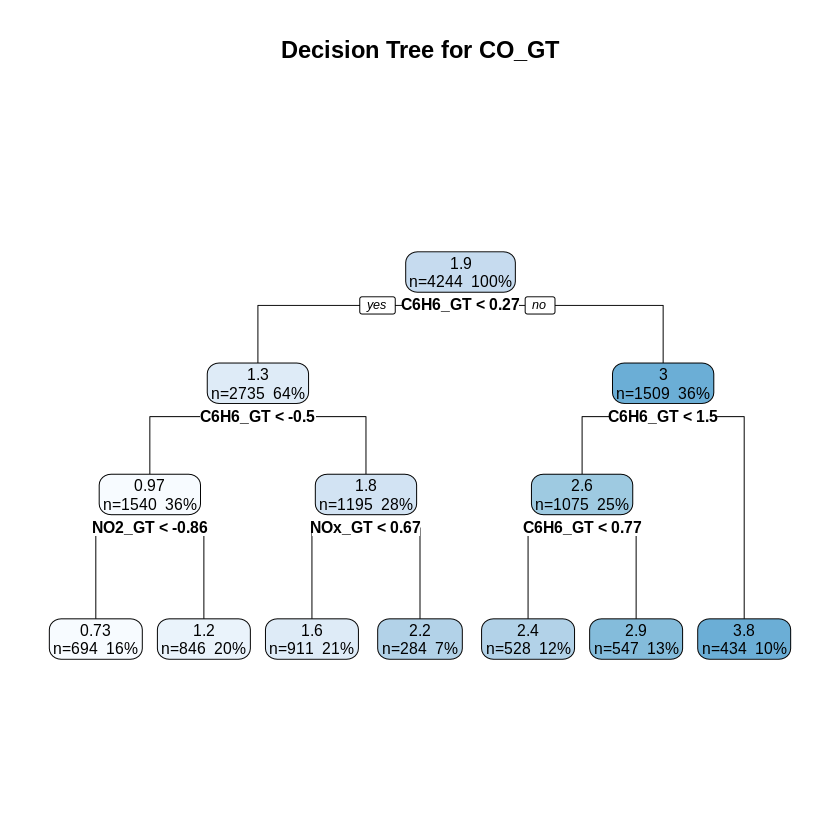

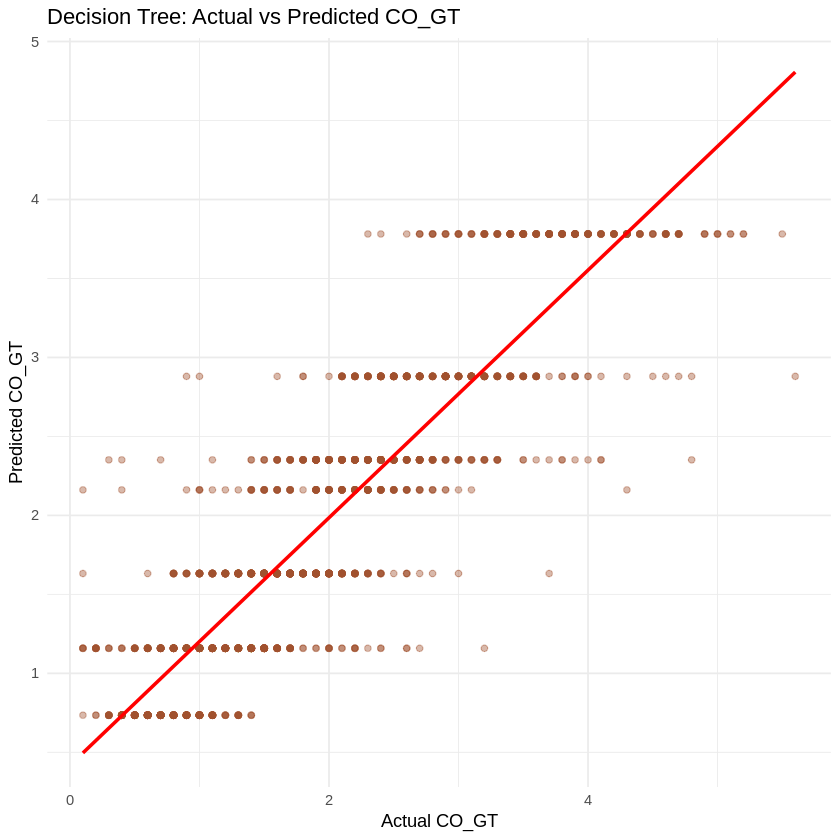

In [33]:

library(rpart)
library(rpart.plot)
library(caret)
library(ggplot2)

# Step 1: Load and clean the data
df <- read.csv("/content/AirQualityUCI_Normalized_CO_Target.csv", stringsAsFactors = FALSE)
df <- df[complete.cases(df), ]

# Step 2: Define features and target
features <- c("RH", "PT08_S1_CO", "C6H6_GT", "PT08_S2_NMHC", "NOx_GT",
              "PT08_S3_NOx", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T", "AH")
target <- "CO_GT"



# Step 4: Train-test split
set.seed(123)
train_index <- createDataPartition(df[[target]], p = 0.7, list = FALSE)
train_data <- df[train_index, ]
test_data <- df[-train_index, ]

# Step 5: Train decision tree model
tree_model <- rpart(CO_GT ~ ., data = train_data[, c(features, target)],
                    method = "anova", control = rpart.control(cp = 0.01))

# Optional: Visualize the tree
rpart.plot(tree_model, type = 2, extra = 101, fallen.leaves = TRUE,
           main = "Decision Tree for CO_GT")

# Step 6: Predict
tree_preds <- predict(tree_model, newdata = test_data[, features])
tree_actuals <- test_data[[target]]

# Step 7: Evaluation
mse <- mean((tree_preds - tree_actuals)^2)
rmse <- sqrt(mse)
mae <- mean(abs(tree_preds - tree_actuals))
r2 <- 1 - sum((tree_preds - tree_actuals)^2) / sum((tree_actuals - mean(tree_actuals))^2)

cat(" Decision Tree Performance:\n")
cat("MSE:", round(mse, 4), "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("MAE:", round(mae, 4), "\n")
cat("R²:", round(r2, 4), "\n")

# Step 8: Plot Actual vs Predicted
ggplot(data.frame(Actual = tree_actuals, Predicted = tree_preds),
       aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.4, color = "sienna") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(title = "Decision Tree: Actual vs Predicted CO_GT",
       x = "Actual CO_GT", y = "Predicted CO_GT") +
  theme_minimal()


 ***XGBoost Model***

 XGBoost Performance:
MSE: 0.119 
RMSE: 0.345 
MAE: 0.228 
R²: 0.8925 


`geom_smooth()` using formula = 'y ~ x'


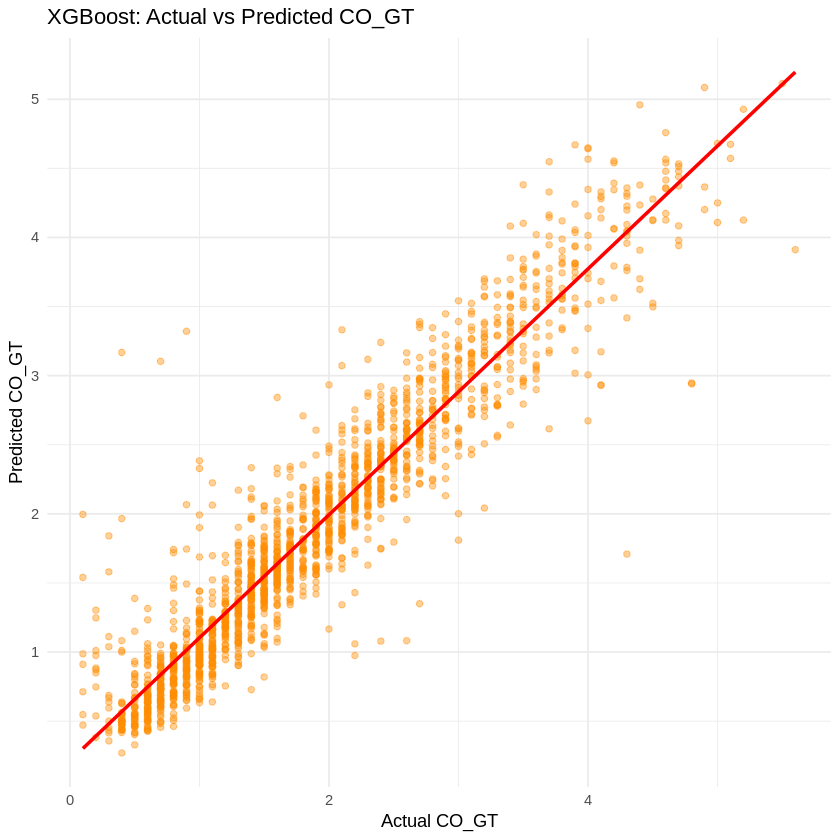

In [29]:

library(xgboost)
library(caret)
library(ggplot2)

# Step 1: Load and clean the dataset
df <- read.csv("/content/AirQualityUCI_Normalized_CO_Target.csv", stringsAsFactors = FALSE)
df <- df[complete.cases(df), ]

# Step 2: Define features and target
features <- c("RH", "PT08_S1_CO", "C6H6_GT", "PT08_S2_NMHC", "NOx_GT",
              "PT08_S3_NOx", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T", "AH")
target <- "CO_GT"



# Step 4: Train-test split
set.seed(123)
train_index <- createDataPartition(df[[target]], p = 0.7, list = FALSE)
train_data <- df[train_index, ]
test_data <- df[-train_index, ]

# Step 5: Convert to matrix format for XGBoost
x_train <- as.matrix(train_data[, features])
y_train <- train_data[[target]]
x_test <- as.matrix(test_data[, features])
y_test <- test_data[[target]]

dtrain <- xgb.DMatrix(data = x_train, label = y_train)
dtest <- xgb.DMatrix(data = x_test, label = y_test)

# Step 6: Set parameters and train model
params <- list(
  objective = "reg:squarederror",
  eval_metric = "rmse"
)

set.seed(123)
xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 200,
  watchlist = list(train = dtrain, test = dtest),
  early_stopping_rounds = 10,
  verbose = 0
)

# Step 7: Predict
xgb_preds <- predict(xgb_model, newdata = dtest)

# Step 8: Evaluation
mse <- mean((xgb_preds - y_test)^2)
rmse <- sqrt(mse)
mae <- mean(abs(xgb_preds - y_test))
r2 <- 1 - sum((xgb_preds - y_test)^2) / sum((y_test - mean(y_test))^2)

cat(" XGBoost Performance:\n")
cat("MSE:", round(mse, 4), "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("MAE:", round(mae, 4), "\n")
cat("R²:", round(r2, 4), "\n")

# Step 9: Actual vs Predicted Plot
ggplot(data.frame(Actual = y_test, Predicted = xgb_preds),
       aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.4, color = "darkorange") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(title = "XGBoost: Actual vs Predicted CO_GT",
       x = "Actual CO_GT", y = "Predicted CO_GT") +
  theme_minimal()


***SVR Model ***

 SVR Performance:
MSE: 0.1076 
RMSE: 0.3281 
MAE: 0.2008 
R²: 0.9027 


`geom_smooth()` using formula = 'y ~ x'


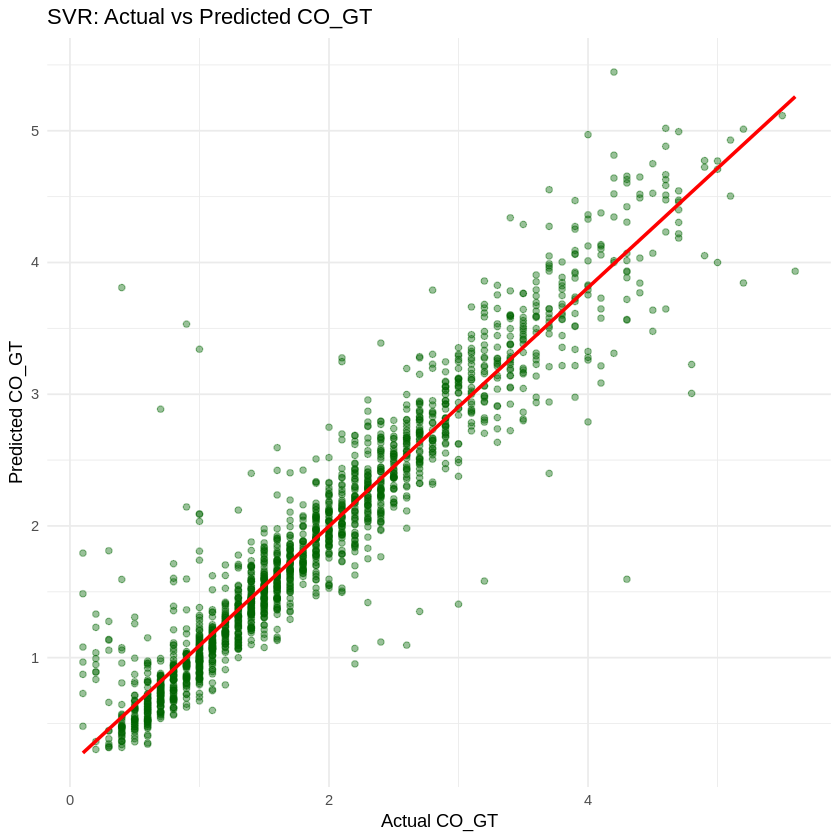

In [27]:

library(e1071)
library(caret)
library(ggplot2)

# Step 1: Load and clean the data
df <- read.csv("/content/AirQualityUCI_Normalized_CO_Target.csv", stringsAsFactors = FALSE)
df <- df[complete.cases(df), ]

# Step 2: Normalize features and target
features <- c("RH", "PT08_S1_CO", "C6H6_GT", "PT08_S2_NMHC", "NOx_GT",
              "PT08_S3_NOx", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T", "AH")
target <- "CO_GT"



# Step 3: Train-test split
set.seed(123)
train_index <- createDataPartition(df[[target]], p = 0.7, list = FALSE)
train_data <- df[train_index, ]
test_data <- df[-train_index, ]

# Step 4: Train SVR model
svr_model <- svm(CO_GT ~ ., data = train_data[, c(features, target)],
                 type = "eps-regression", kernel = "radial", cost = 10, epsilon = 0.01)

# Step 5: Predict
svr_preds <- predict(svr_model, newdata = test_data[, features])
svr_actuals <- test_data[[target]]

# Step 6: Evaluation metrics
mse <- mean((svr_preds - svr_actuals)^2)
rmse <- sqrt(mse)
mae <- mean(abs(svr_preds - svr_actuals))
r2 <- 1 - sum((svr_preds - svr_actuals)^2) / sum((svr_actuals - mean(svr_actuals))^2)

cat(" SVR Performance:\n")
cat("MSE:", round(mse, 4), "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("MAE:", round(mae, 4), "\n")
cat("R²:", round(r2, 4), "\n")

# Step 7: Actual vs Predicted Plot
ggplot(data.frame(Actual = svr_actuals, Predicted = svr_preds),
       aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.4, color = "darkgreen") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(title = "SVR: Actual vs Predicted CO_GT",
       x = "Actual CO_GT", y = "Predicted CO_GT") +
  theme_minimal()


*** Neural Network Model***

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



 Neural Network Performance:
MSE: 0.1161 
RMSE: 0.3407 
MAE: 0.2207 
R²: 0.8951 


`geom_smooth()` using formula = 'y ~ x'


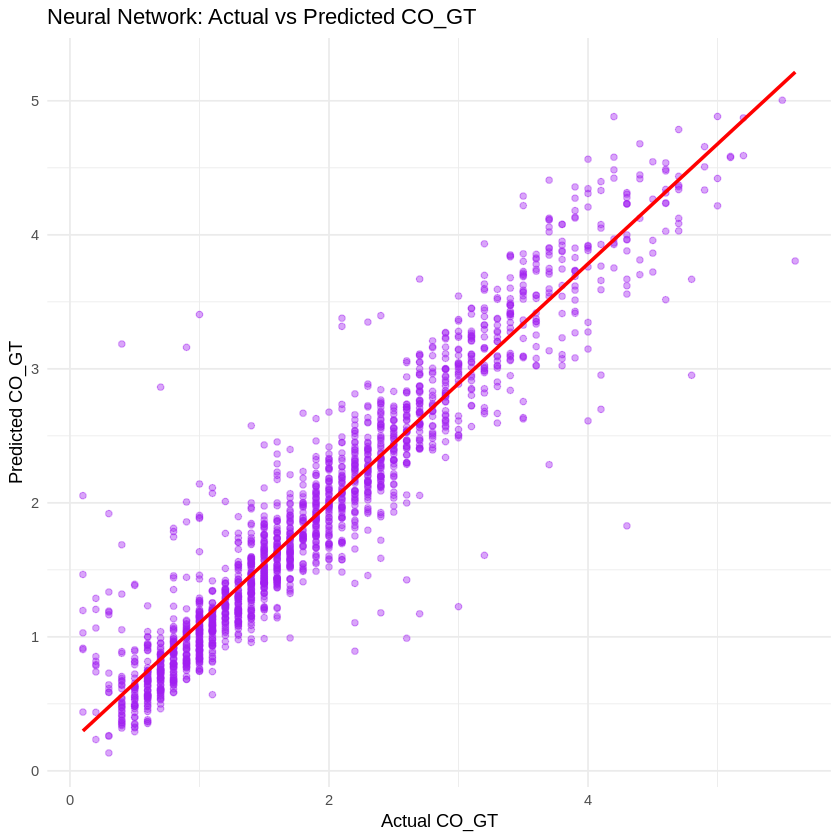

In [28]:
# Install and load necessary packages
install.packages("nnet")
library(nnet)
library(caret)
library(ggplot2)
library(scales)  # for plotting

# Step 1: Load and clean the dataset
df <- read.csv("/content/AirQualityUCI_Normalized_CO_Target.csv", stringsAsFactors = FALSE)
df <- df[complete.cases(df), ]

# Step 2: Normalize features (Neural nets perform better when scaled)
features <- c("RH", "PT08_S1_CO", "C6H6_GT", "PT08_S2_NMHC", "NOx_GT",
              "PT08_S3_NOx", "NO2_GT", "PT08_S4_NO2", "PT08_S5_O3", "T", "AH")
target <- "CO_GT"



# Step 3: Train-test split
set.seed(123)
train_index <- createDataPartition(df[[target]], p = 0.7, list = FALSE)
df_train <- df[train_index, ]
df_test <- df[-train_index, ]

# Step 4: Fit a neural network model
# size = number of hidden units, linout = TRUE for regression
set.seed(123)
nn_model <- nnet(CO_GT ~ ., data = df_train[, c(features, target)],
                 size = 5, linout = TRUE, decay = 0.01, maxit = 500, trace = FALSE)

# Step 5: Predict
nn_preds <- predict(nn_model, newdata = df_test[, features])
nn_actuals <- df_test[[target]]

# Step 6: Evaluation Metrics
mse_nn <- mean((nn_preds - nn_actuals)^2)
rmse_nn <- sqrt(mse_nn)
mae_nn <- mean(abs(nn_preds - nn_actuals))
r2_nn <- 1 - sum((nn_preds - nn_actuals)^2) / sum((nn_actuals - mean(nn_actuals))^2)

cat(" Neural Network Performance:\n")
cat("MSE:", round(mse_nn, 4), "\n")
cat("RMSE:", round(rmse_nn, 4), "\n")
cat("MAE:", round(mae_nn, 4), "\n")
cat("R²:", round(r2_nn, 4), "\n")

# Step 7: Actual vs Predicted Plot
ggplot(data.frame(Actual = nn_actuals, Predicted = nn_preds),
       aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.4, color = "purple") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(title = "Neural Network: Actual vs Predicted CO_GT",
       x = "Actual CO_GT", y = "Predicted CO_GT") +
  theme_minimal()


***Performance Metrics Summary ***

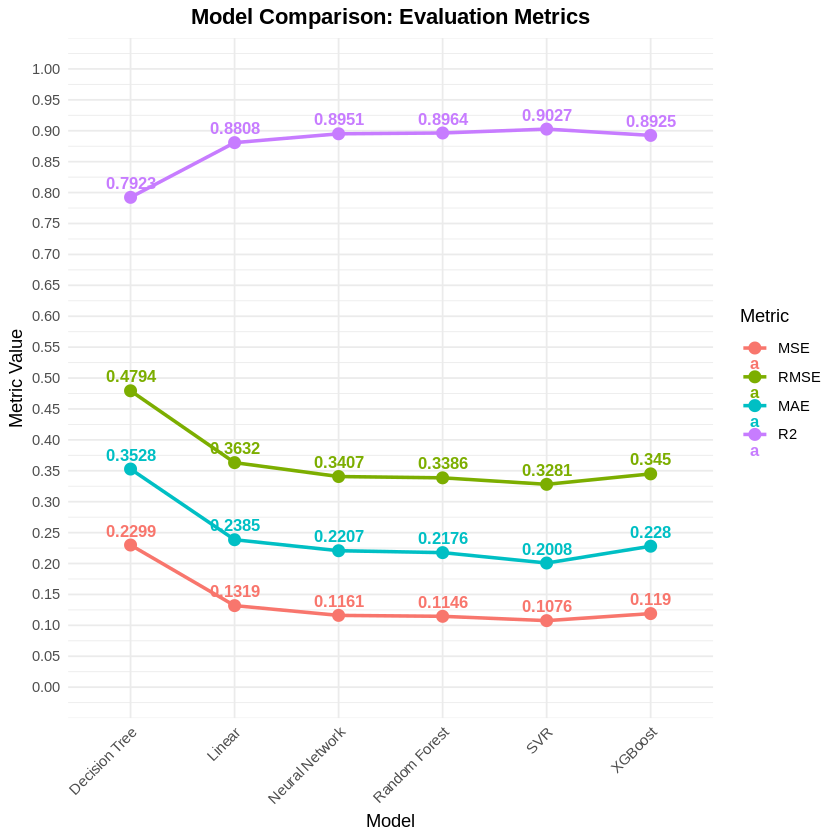

In [36]:
library(ggplot2)
library(reshape2)

# Step 1: Create the performance table
results_df <- data.frame(
  Model = c("Linear", "Random Forest", "Decision Tree", "XGBoost", "SVR", "Neural Network"),
  MSE = c(0.1319, 0.1146, 0.2299, 0.119, 0.1076, 0.1161),
  RMSE = c(0.3632, 0.3386, 0.4794, 0.345, 0.3281, 0.3407),
  MAE = c(0.2385, 0.2176, 0.3528, 0.228, 0.2008, 0.2207),
  R2 = c(0.8808, 0.8964, 0.7923, 0.8925, 0.9027, 0.8951)
)

# Step 2: Reshape for ggplot
results_long <- melt(results_df, id.vars = "Model", variable.name = "Metric", value.name = "Value")

# Step 3: Plot with custom Y-axis breaks
ggplot(results_long, aes(x = Model, y = Value, group = Metric, color = Metric)) +
  geom_line(linewidth = 1) +
  geom_point(size = 3) +
  geom_text(aes(label = round(Value, 4)), vjust = -0.7, size = 3.5, fontface = "bold") +
  scale_y_continuous(
    breaks = seq(0, 1, by = 0.05),  # more scale granularity
    limits = c(0, 1)
  ) +
  labs(
    title = "Model Comparison: Evaluation Metrics",
    x = "Model",
    y = "Metric Value"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(face = "bold", hjust = 0.5)
  )
